In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning) 
warnings.simplefilter("ignore", UserWarning)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

n_jobs = -1

In [2]:
train=pd.read_csv('../../1. Task and Data/train.csv',sep='|')

In [3]:
print(train.fraud.value_counts())
print(train.fraud.value_counts() / len(train))

0    1775
1     104
Name: fraud, dtype: int64
0    0.944651
1    0.055349
Name: fraud, dtype: float64


# Feature Engineering

In [44]:
train['scannedLineItems'] = train['scannedLineItemsPerSecond'] * train['totalScanTimeInSeconds']
train['pricePerScannedLineItem'] = train['grandTotal'] / train['scannedLineItems']
train['scansWithoutRegistrationPerScannedLineItem'] = train['scansWithoutRegistration'] / train['scannedLineItems']
train['quantityModificationsPerScannedLineItem'] = train['quantityModifications'] / train['scannedLineItems']
train['lineItemVoidsPerSecond'] = train['lineItemVoids'] / train['totalScanTimeInSeconds']
train['scansWithoutRegistrationPerSecond'] = train['scansWithoutRegistration'] / train['totalScanTimeInSeconds']
train['quantityModificationsPerSecond'] = train['quantityModifications'] / train['totalScanTimeInSeconds']
train['secondsPerEuro'] = train['totalScanTimeInSeconds'] / train['grandTotal']
train['lineItemVoidsPerEuro'] = train['lineItemVoids'] / train['grandTotal']
train['scansWithoutRegistrationPerEuro'] = train['scansWithoutRegistration'] / train['grandTotal']
train['quantityModificationsPerEuro'] = train['quantityModifications'] / train['grandTotal']

In [45]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer


def my_custom_loss_func(y_true, y_pred):
    cm = confusion_matrix(y_true,y_pred)
    tn, fp, fn, tp = cm.ravel()
    score = ((-25)*fp + (-5)*fn + 5*tp) / len(y_true)
    return (score)

my_custom_score = make_scorer(my_custom_loss_func, greater_is_better=True)

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut

skf = StratifiedKFold(n_splits=10)

In [46]:
#Reduce data sample to test loop structure
train = train.sample(frac=0.5, replace=True)


# Model factory

In [47]:
#!pip install imblearn --user

In [48]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


from imblearn.pipeline import Pipeline
#Create multiple pipelines for different oversampling methods

pipeline_1 = Pipeline([
        ('sampling', SMOTE()), #simple change oversampling method here and import it above, parameters could be tuned as well
        ('classification', RandomForestClassifier())
    ])

pipeline_2 = Pipeline([
        ('sampling', ADASYN()), #simple change oversampling method here and import it above, parameters could be tuned as well
        ('classification', RandomForestClassifier())
    ])

pipeline_3 = Pipeline([
        ('sampling', RandomOverSampler()), #simple change oversampling method here and import it above, parameters could be tuned as well
        ('classification', RandomForestClassifier())
    ])


model_tuning_factory = [
    GridSearchCV(pipeline_1,
                 dict(classification__n_estimators = range(5,200,5),
                      classification__criterion = ['entropy', 'gini']),
                 cv = skf,
                 scoring = my_custom_score,
                 n_jobs = -1),
    GridSearchCV(pipeline_2,
                 dict(classification__n_estimators = range(5,200,5),
                      classification__criterion = ['entropy', 'gini']),
                 cv = skf,
                 scoring = my_custom_score,
                 n_jobs = -1),
    GridSearchCV(pipeline_3,
                 dict(classification__n_estimators = range(5,200,5),
                      classification__criterion = ['entropy', 'gini']),
                 cv = skf,
                 scoring = my_custom_score,
                 n_jobs = -1)
]           
                 
                 
iterations = 10                
               
model_tuning_factory_randomized = [
    RandomizedSearchCV(RandomForestClassifier(),
                 dict(n_estimators = range(5,200,5),
                      criterion = ['entropy', 'gini']),
                 cv = skf,
                 scoring = my_custom_score,
                      n_iter  = iterations)
]


In [49]:
Y = train['fraud']
X = train.drop('fraud',axis=1)

In [50]:
import time
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE

from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

result_table = pd.DataFrame(columns=["Model", "Data Preparation", "Feature Count", "Features", "Optimal Parameters", "Monetary Value Per Instance - Mean", "Monetary Value Per Instance - Standard Deviation", "Raw Model"])


# Scaling is not relevant for Decision Trees
for data_preparation_strategy in range(1,2):
    if (data_preparation_strategy == 1):  
        X_scaled = X
        data_preparation = "No Scaling"
    elif (data_preparation_strategy == 2):
        feature_scaler = MinMaxScaler()  
        X_scaled = pd.DataFrame(feature_scaler.fit_transform(X.values), columns=X.columns, index=X.index) 
        data_preparation = "MinMaxScaler"
    elif (data_preparation_strategy == 3):
        feature_scaler = StandardScaler()  
        X_scaled = pd.DataFrame(feature_scaler.fit_transform(X.values), columns=X.columns, index=X.index)
        data_preparation = "StandardScaler"
    elif (data_preparation_strategy == 4):
        transformer = FunctionTransformer(np.log1p, validate=True)  
        X_scaled = pd.DataFrame(transformer.transform(X), columns=X.columns, index=X.index)
        data_preparation = "LogScaler"    

    for model in model_tuning_factory:   # replace with model_tuning_factory_randomized for faster results


        for feature_count in range(1,len(list(X))+1):

            model.seed = 42
            start_time = time.time()              


            # Solution with SelectKBest
            best_features = SelectKBest(f_classif, k=feature_count).fit(X_scaled,Y)
            best_feature_list = X.columns[best_features.get_support()]
            X_selected_features = X[best_feature_list]

            model.fit(X_selected_features,Y)  
            model_name = model.best_estimator_.__class__.__name__
            score_mean = model.cv_results_['mean_test_score'][model.best_index_]
            score_std = model.cv_results_['std_test_score'][model.best_index_]

            result_table = result_table.append({
             "Model": model_name, 
             "Data Preparation": data_preparation,   
             "Feature Count": feature_count,
             "Feature Selection Technique": "SelectKBest",   
             "Features": best_feature_list.values, 
             "Optimal Parameters": model.best_params_,
             "Monetary Value Per Instance - Mean":  score_mean,
             "Monetary Value Per Instance - Standard Deviation": score_std,   
             "Raw Model": model.best_estimator_
              }, ignore_index=True)


            # Solution with Recursive Feature Elimination -> only works for some models

            if (model.estimator.__class__.__name__ == 'LogisticRegression'
             or model.estimator.__class__.__name__ == 'DecisionTreeClassifier'
             or model.estimator.__class__.__name__ == 'ExtraTreeClassifier'
             or model.estimator.__class__.__name__ == 'ExtraTreesClassifier'
             or model.estimator.__class__.__name__ == 'RandomForestClassifier'
             or model.estimator.__class__.__name__ == 'BernoulliNB'
             or model.estimator.__class__.__name__ == 'AdaBoostClassifier'
             or model.estimator.__class__.__name__ == 'GradientBoostingClassifier'
             or model.estimator.__class__.__name__ == 'Perceptron'
             or model.estimator.__class__.__name__ == 'LinearDiscriminantAnalysis'):

               # Traditional RFE
                rfe = RFE(model.estimator, n_features_to_select = feature_count)
                rfe = rfe.fit(X,Y)
                best_feature_list = np.array(list(X))[np.array(rfe.support_)]
                X_selected_features = X[best_feature_list]

                model.fit(X_selected_features,Y)  
                model_name = model.best_estimator_.__class__.__name__
                score_mean = model.cv_results_['mean_test_score'][model.best_index_]
                score_std = model.cv_results_['std_test_score'][model.best_index_]


                result_table = result_table.append({
                 "Model": model_name, 
                 "Data Preparation": data_preparation,
                 "Feature Count": feature_count,
                 "Feature Selection Technique": "RFE",
                 "Features": best_feature_list,
                 "Optimal Parameters": model.best_params_,
                 "Monetary Value Per Instance - Mean":  score_mean,
                 "Monetary Value Per Instance - Standard Deviation": score_std,  
                 "Raw Model": model.best_estimator_
                  }, ignore_index=True)

            end_time = time.time()

            print("Finished " + model.best_estimator_.__class__.__name__ + " with " + data_preparation + " and " + str(feature_count) + " features after " + str(round(end_time - start_time, 2)) + " seconds")



        if (model.estimator.__class__.__name__ == 'LogisticRegression'
         or model.estimator.__class__.__name__ == 'DecisionTreeClassifier'
         or model.estimator.__class__.__name__ == 'ExtraTreeClassifier'
         or model.estimator.__class__.__name__ == 'ExtraTreesClassifier'
         or model.estimator.__class__.__name__ == 'RandomForestClassifier'
         or model.estimator.__class__.__name__ == 'BernoulliNB'
         or model.estimator.__class__.__name__ == 'AdaBoostClassifier'
         or model.estimator.__class__.__name__ == 'GradientBoostingClassifier'
         or model.estimator.__class__.__name__ == 'Perceptron'
         or model.estimator.__class__.__name__ == 'LinearDiscriminantAnalysis'):

            # RFE with Cross Validation -> determines the optimum feature count automatically
            rfecv = RFECV(model.estimator, cv = skf, scoring = my_custom_score)
            rfecv = rfe.fit(X,Y)
            best_feature_list = np.array(list(X))[np.array(rfecv.support_)]
            X_selected_features = X[best_feature_list]

            model.fit(X_selected_features,Y)  
            model_name = model.best_estimator_.__class__.__name__
            score_mean = model.cv_results_['mean_test_score'][model.best_index_]
            score_std = model.cv_results_['std_test_score'][model.best_index_]


            result_table = result_table.append({
             "Model": model_name,  
             "Data Preparation": data_preparation,
             "Feature Count": len(best_feature_list),
             "Feature Selection Technique": "RFECV",
             "Features": best_feature_list,
             "Optimal Parameters": model.best_params_,
             "Monetary Value Per Instance - Mean":  score_mean,
             "Monetary Value Per Instance - Standard Deviation": score_std,    
             "Raw Model": model.best_estimator_
              }, ignore_index=True)

result_table.sort_values(by = "Monetary Value Per Instance - Mean", ascending = False)

Finished Pipeline with No Scaling and 1 features after 40.43 seconds
Finished Pipeline with No Scaling and 2 features after 36.59 seconds
Finished Pipeline with No Scaling and 3 features after 40.57 seconds
Finished Pipeline with No Scaling and 4 features after 37.9 seconds
Finished Pipeline with No Scaling and 5 features after 37.6 seconds
Finished Pipeline with No Scaling and 6 features after 43.03 seconds
Finished Pipeline with No Scaling and 7 features after 40.29 seconds
Finished Pipeline with No Scaling and 8 features after 43.69 seconds
Finished Pipeline with No Scaling and 9 features after 49.94 seconds
Finished Pipeline with No Scaling and 10 features after 45.56 seconds
Finished Pipeline with No Scaling and 11 features after 49.44 seconds
Finished Pipeline with No Scaling and 12 features after 48.8 seconds
Finished Pipeline with No Scaling and 13 features after 43.03 seconds
Finished Pipeline with No Scaling and 14 features after 44.9 seconds
Finished Pipeline with No Scaling

,Model,Data Preparation,Feature Count,Features,Optimal Parameters,Monetary Value Per Instance - Mean,Monetary Value Per Instance - Standard Deviation,Raw Model,Feature Selection Technique
47,Pipeline,No Scaling,8,"[trustLevel, totalScanTimeInSeconds, scansWith...","{'classification__criterion': 'gini', 'classif...",-0.159574,0.467217,"(RandomOverSampler(random_state=None, ratio=No...",SelectKBest
10,Pipeline,No Scaling,11,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'classification__criterion': 'gini', 'classif...",-0.186170,0.684401,"(SMOTE(k_neighbors=5, kind='deprecated', m_nei...",SelectKBest
48,Pipeline,No Scaling,9,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'classification__criterion': 'gini', 'classif...",-0.186170,0.541587,"(RandomOverSampler(random_state=None, ratio=No...",SelectKBest
6,Pipeline,No Scaling,7,"[trustLevel, totalScanTimeInSeconds, scansWith...","{'classification__criterion': 'gini', 'classif...",-0.212766,0.754062,"(SMOTE(k_neighbors=5, kind='deprecated', m_nei...",SelectKBest
49,Pipeline,No Scaling,10,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'classification__criterion': 'entropy', 'clas...",-0.239362,0.571042,"(RandomOverSampler(random_state=None, ratio=No...",SelectKBest
59,Pipeline,No Scaling,20,"[trustLevel, totalScanTimeInSeconds, grandTota...","{'classification__criterion': 'gini', 'classif...",-0.265957,0.446786,"(RandomOverSampler(random_state=None, ratio=No...",SelectKBest
27,Pipeline,No Scaling,8,"[trustLevel, totalScanTimeInSeconds, scansWith...","{'classification__criterion': 'entropy', 'clas...",-0.265957,0.884595,"(ADASYN(n_jobs=1, n_neighbors=5, random_state=...",SelectKBest
28,Pipeline,No Scaling,9,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'classification__criterion': 'gini', 'classif...",-0.265957,0.718714,"(ADASYN(n_jobs=1, n_neighbors=5, random_state=...",SelectKBest
43,Pipeline,No Scaling,4,"[trustLevel, totalScanTimeInSeconds, scansWith...","{'classification__criterion': 'entropy', 'clas...",-0.265957,0.660321,"(RandomOverSampler(random_state=None, ratio=No...",SelectKBest
26,Pipeline,No Scaling,7,"[trustLevel, totalScanTimeInSeconds, scansWith...","{'classification__criterion': 'gini', 'classif...",-0.265957,0.884595,"(ADASYN(n_jobs=1, n_neighbors=5, random_state=...",SelectKBest


In [51]:
result_table.sort_values(by = "Monetary Value Per Instance - Mean", ascending = False)

,Model,Data Preparation,Feature Count,Features,Optimal Parameters,Monetary Value Per Instance - Mean,Monetary Value Per Instance - Standard Deviation,Raw Model,Feature Selection Technique
47,Pipeline,No Scaling,8,"[trustLevel, totalScanTimeInSeconds, scansWith...","{'classification__criterion': 'gini', 'classif...",-0.159574,0.467217,"(RandomOverSampler(random_state=None, ratio=No...",SelectKBest
10,Pipeline,No Scaling,11,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'classification__criterion': 'gini', 'classif...",-0.186170,0.684401,"(SMOTE(k_neighbors=5, kind='deprecated', m_nei...",SelectKBest
48,Pipeline,No Scaling,9,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'classification__criterion': 'gini', 'classif...",-0.186170,0.541587,"(RandomOverSampler(random_state=None, ratio=No...",SelectKBest
6,Pipeline,No Scaling,7,"[trustLevel, totalScanTimeInSeconds, scansWith...","{'classification__criterion': 'gini', 'classif...",-0.212766,0.754062,"(SMOTE(k_neighbors=5, kind='deprecated', m_nei...",SelectKBest
49,Pipeline,No Scaling,10,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'classification__criterion': 'entropy', 'clas...",-0.239362,0.571042,"(RandomOverSampler(random_state=None, ratio=No...",SelectKBest
59,Pipeline,No Scaling,20,"[trustLevel, totalScanTimeInSeconds, grandTota...","{'classification__criterion': 'gini', 'classif...",-0.265957,0.446786,"(RandomOverSampler(random_state=None, ratio=No...",SelectKBest
27,Pipeline,No Scaling,8,"[trustLevel, totalScanTimeInSeconds, scansWith...","{'classification__criterion': 'entropy', 'clas...",-0.265957,0.884595,"(ADASYN(n_jobs=1, n_neighbors=5, random_state=...",SelectKBest
28,Pipeline,No Scaling,9,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'classification__criterion': 'gini', 'classif...",-0.265957,0.718714,"(ADASYN(n_jobs=1, n_neighbors=5, random_state=...",SelectKBest
43,Pipeline,No Scaling,4,"[trustLevel, totalScanTimeInSeconds, scansWith...","{'classification__criterion': 'entropy', 'clas...",-0.265957,0.660321,"(RandomOverSampler(random_state=None, ratio=No...",SelectKBest
26,Pipeline,No Scaling,7,"[trustLevel, totalScanTimeInSeconds, scansWith...","{'classification__criterion': 'gini', 'classif...",-0.265957,0.884595,"(ADASYN(n_jobs=1, n_neighbors=5, random_state=...",SelectKBest


In [52]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'sampling', 'classification', 'sampling__k_neighbors', 'sampling__kind', 'sampling__m_neighbors', 'sampling__n_jobs', 'sampling__out_step', 'sampling__random_state', 'sampling__ratio', 'sampling__sampling_strategy', 'sampling__svm_estimator', 'classification__bootstrap', 'classification__class_weight', 'classification__criterion', 'classification__max_depth', 'classification__max_features', 'classification__max_leaf_nodes', 'classification__min_impurity_decrease', 'classification__min_impurity_split', 'classification__min_samples_leaf', 'classification__min_samples_split', 'classification__min_weight_fraction_leaf', 'classification__n_estimators', 'classification__n_jobs', 'classification__oob_score', 'classification__random_state', 'classification__verbose', 'classification__warm_start'])

In [53]:
result_table.to_pickle("result_table_Random_Forest.pkl")
#result_table = pd.read_pickle("result_table_Random_Forest.pkl")

Text(0,0.5,'Monetary Value Per Instance - Mean')

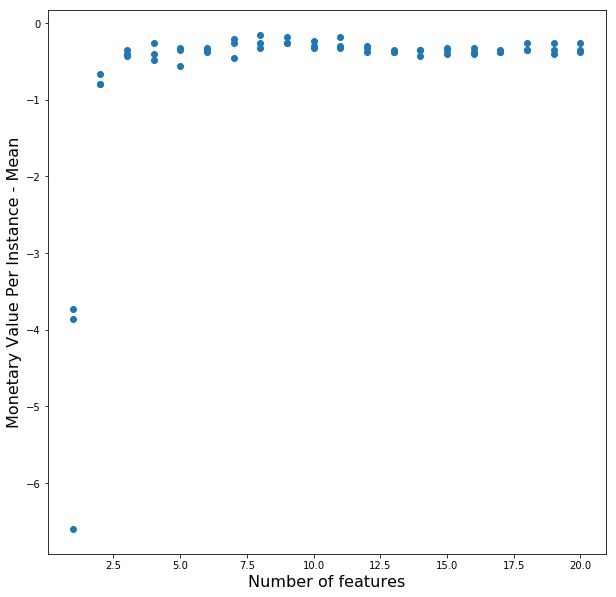

In [54]:
plt.rcParams['figure.figsize'] = (10,10)

plt.scatter(result_table["Feature Count"], result_table["Monetary Value Per Instance - Mean"])
plt.xlabel('Number of features', fontsize=16)
plt.ylabel('Monetary Value Per Instance - Mean', fontsize=16)

In [55]:
best_model = result_table.loc[result_table["Monetary Value Per Instance - Mean"].argmax()]["Raw Model"]
best_model_features = result_table.loc[result_table["Monetary Value Per Instance - Mean"].argmax()]["Features"]
best_parameters = result_table.loc[result_table["Monetary Value Per Instance - Mean"].argmax()]["Optimal Parameters"]

print(best_model)
print(best_model_features)
print(best_parameters)

Pipeline(memory=None,
         steps=[('sampling',
                 RandomOverSampler(random_state=None, ratio=None,
                                   return_indices=False,
                                   sampling_strategy='auto')),
                ('classification',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=30, n_jobs=None,
                                        oob_score=False, random_state=None,
                            

In [56]:
from sklearn.metrics import confusion_matrix

def get_monetary_value(cm):
        tn, fp, fn, tp = cm.ravel()
        print("True negative: ", tn)
        print("False positive: ", fp)
        print("False negative: ", fn)
        print("True positive: ", tp)
        score = (-25)*fp + (-5)*fn + 5*tp
        print(str(score) + " for " + str(sum(sum(cm))) + " instances in the test set")
        print(str(score/sum(sum(cm))) + " per instance in the test set")
        return score
    
cm = confusion_matrix(Y , best_model.predict(X[best_model_features]))

monetary_value = get_monetary_value(cm)

True negative:  175
False positive:  0
False negative:  0
True positive:  13
65 for 188 instances in the test set
0.34574468085106386 per instance in the test set
